# Local HRV measurement

Heart rate and heart rate variability are features of cardiac activity that seem to vary meaningfully during music performance and listening. However, traditional estimates of individual's heart rate and features of heart rate variability are usually calculated over longer time intervals, minutes or hours rather than seconds or beat by beat, and these calculations are not all suitable for active conditions where physical activity is a substantial contributor to these features values in time.

In order to investigate the temporal dynamics of cardiac activity at a time scale relevant to the actions and conscious experience of musical activities, we need reliable robust calculations for extremely local values, per beat if possible, that also untangle cardiac qualities of interest. 

Some of the challenges for higher temporal resolution on these features is a matter of signal reliability. The cardiac features of interest are all derived from measured cardiac IBIs, interbeat-intervals. Active measurement conditions such as music playing or dancing can produce interference that disturb the reliability of beat detection and infered timing from most sensor systems. Automated data cleaning and strategies to acknowledge, navigate around, and compensate for missing data is necessary for higher resolution data handling. 

Using IBIs recorded from musicians and listeners during live performances. this notebook presents comparisons and recommendations for assessing local HRV. IBI cleaning and HR features are discussed in the LocalHR notebook.

This analysis includes arguments about the repeatability of these measurement values across repeated performances, the consistency of values between performers playing similar parts, and the seperability of HR and HRV in these measurement conditions. 

# Code libraries, published and local

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heartpy as hp
import pingouin as pg

from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al
%aimport eq
%aimport rp
%aimport mh

In [3]:
%reload_ext autoreload

In [4]:
data_loc = './demodata/'
demofiles = os.listdir(data_loc)
plot_loc = './plots/'
mydpi = 196

# Local Heart Rate Variability

Staying within the time domain, how local and how reliable can we make HRV calculations? How does changing heart rate affect these different calculations of HRV?

### Ratio vs ms difference 

### Quantiles vs Mean Square (Contributions of HR to HRV)

### Beat range and reliability (10 vs 30 bts)

### Time interval vs beats counts

### Final rec and conditions

In [24]:
def hrv_beatfeats(sig_t,sig_v):
    # assume cleaned with mh.IBI_clean, then hrv_beatfeats(IBI.index,IBI.IBI)
    min_per = 5

    df_card = pd.DataFrame(index = sig_t)
    df_card['IBI'] = sig_v 

    df_card.loc[:,'HRV10bt_ms'] = sig_v.diff().pow(2).rolling(10,center=True,min_periods=min_per).mean().pow(0.5)
    df_card.loc[:,'HRV30bt_ms'] = sig_v.diff().pow(2).rolling(30,center=True,min_periods=min_per).mean().pow(0.5)
    df_card.loc[:,'HRV10bt_qms'] = sig_v.diff().rolling(10,center=True,min_periods=min_per).quantile(0.75)-sig_v.diff().rolling(10,center=True,min_periods=min_per).quantile(0.25)
    df_card.loc[:,'HRV30bt_qms'] = sig_v.diff().rolling(30,center=True,min_periods=min_per).quantile(0.75)-sig_v.diff().rolling(30,center=True,min_periods=min_per).quantile(0.25)

    a = sig_v.astype(float)
    division = pd.Series(np.divide(a.values[1:],a.values[:-1]))
    a.iloc[1:] = division
    a.iloc[0]=1
    a.iloc[-1]=1
    df_card.loc[:,'HRV10bt_r'] = (a-1).abs().rolling(10,center=True,min_periods=min_per).median()+1
    df_card.loc[:,'HRV30bt_r'] = (a-1).abs().rolling(30,center=True,min_periods=min_per).median()+1
    a = np.log2(a)
    df_card.loc[:,'HRV10bt_ar'] = np.exp2(a.rolling(10,center=True,min_periods=min_per).quantile(0.75)-a.rolling(10,center=True,min_periods=min_per).quantile(0.25))
    df_card.loc[:,'HRV30bt_ar']  = np.exp2(a.rolling(30,center=True,min_periods=min_per).quantile(0.75)-a.rolling(30,center=True,min_periods=min_per).quantile(0.25))
 
    return df_card

# Standard HRV, from rrms

To get a sense of how HRV may be varying locally in relationship to musical activity, we are trying a number of calculations to capture beat-wise variation in beat durations. 

The most common HRV calculation in the time domain is RRMS, the average absolute successive difference in beat duration, in miliseconds.

Usually this is calcualted over several minutes. Because of the temporal dynamics of musical tasks, we are testing out calculations on smaller intervals, 10 and 30 beats, so around 7 s to 22 s, on average. 

Alternatives we are trying as well: median ratio difference, similar to RRMS but calculated as the proportion of beat duration rather than in the units of ms, and quantile ranges on these (ms and ratio) to reduce prominence of change due to work demands. 

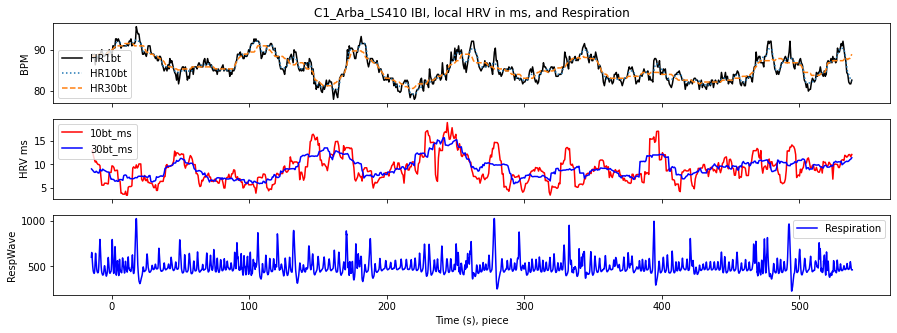

In [31]:
sig_ex = 'C1_Arba_LS410'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(HRV.index,HRV['HRV10bt_ms'],color = 'r',label='10bt_ms')
ax[1].plot(HRV.index,HRV['HRV30bt_ms'],color = 'b',label='30bt_ms')
ax[1].set_ylabel('HRV ms')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV in ms, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRVms','Resp'])+'.png',dpi=mydpi)
plt.show()

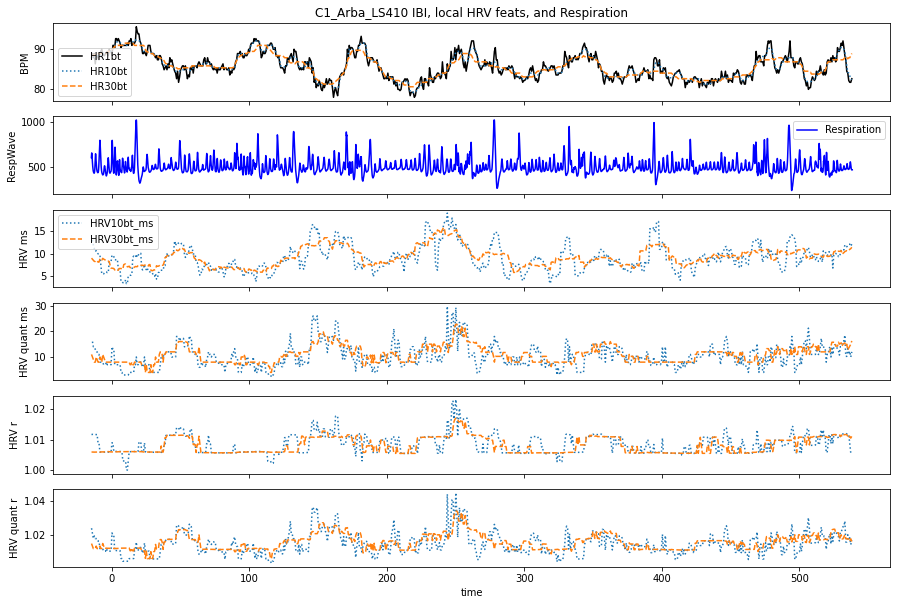

In [36]:
sig_ex = 'C1_Arba_LS410'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(6, 1,figsize = [15,10],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[1].set_xlabel('Time (s), piece')
ax[1].set_ylabel('RespWave')
HRV['HRV10bt_ms'].plot(ax=ax[2],style=':')
HRV['HRV30bt_ms'].plot(ax=ax[2],style='--')
ax[2].set_ylabel('HRV ms')
HRV['HRV10bt_qms'].plot(ax=ax[3],style=':')
HRV['HRV30bt_qms'].plot(ax=ax[3],style='--')
ax[3].set_ylabel('HRV quant ms')
HRV['HRV10bt_r'].plot(ax=ax[4],style=':')
HRV['HRV30bt_r'].plot(ax=ax[4],style='--')
ax[4].set_ylabel('HRV r')
HRV['HRV10bt_ar'].plot(ax=ax[5],style=':')
HRV['HRV30bt_ar'].plot(ax=ax[5],style='--')
ax[5].set_ylabel('HRV quant r')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV feats, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV','Resp'])+'.png',dpi=mydpi)
plt.show()

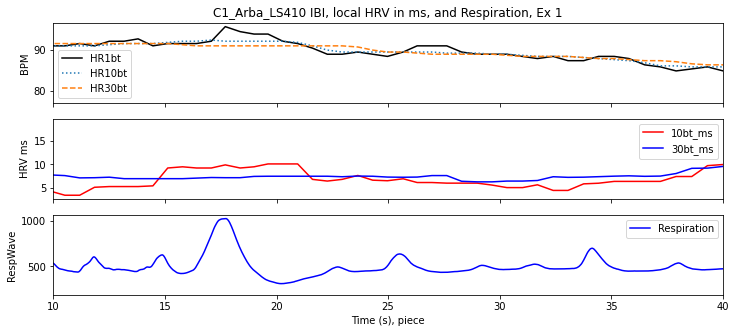

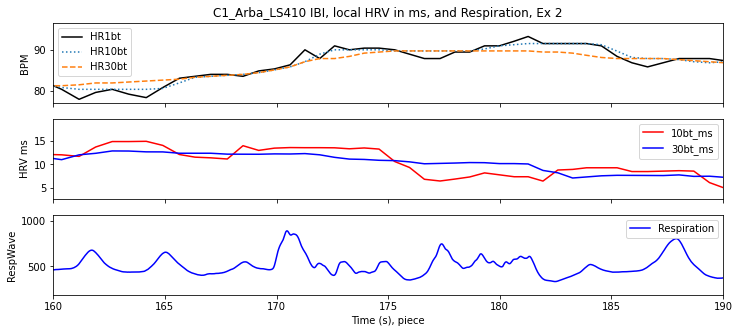

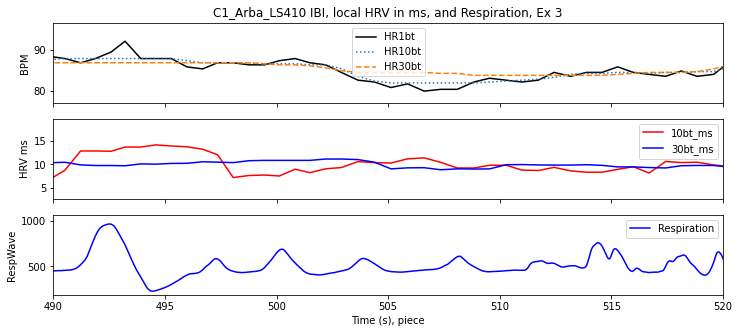

In [33]:
fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(HRV.index,HRV['HRV10bt_ms'],color = 'r',label='10bt_ms')
ax[1].plot(HRV.index,HRV['HRV30bt_ms'],color = 'b',label='30bt_ms')
ax[1].set_ylabel('HRV ms')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_xlim([10,40])
ax[0].set_title(sig_ex +' IBI, local HRV in ms, and Respiration, Ex 1')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRVms','Resp','ex1'])+'.png',dpi=mydpi)
plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(HRV.index,HRV['HRV10bt_ms'],color = 'r',label='10bt_ms')
ax[1].plot(HRV.index,HRV['HRV30bt_ms'],color = 'b',label='30bt_ms')
ax[1].set_ylabel('HRV ms')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_xlim([160,190])
ax[0].set_title(sig_ex +' IBI, local HRV in ms, and Respiration, Ex 2')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRVms','Resp','ex2'])+'.png',dpi=mydpi)
                
plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(HRV.index,HRV['HRV10bt_ms'],color = 'r',label='10bt_ms')
ax[1].plot(HRV.index,HRV['HRV30bt_ms'],color = 'b',label='30bt_ms')
ax[1].set_ylabel('HRV ms')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_xlim([490,520])
ax[0].set_title(sig_ex +' IBI, local HRV in ms, and Respiration, Ex 3')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRVms','Resp','ex3'])+'.png',dpi=mydpi)
plt.show()

### Deviant heart beats

One example of noise in IBI signals that are routinely removed from Heart Rate and Heart Rate Variance measurements are true deviations of heat beats that are one off skips seamingly not related to local (10-20s) trajectory of cardiac features. 

In a recording from conductor, the IBIs extracted from the EQ 2 line ECG recordings are fairly clean and orderly but there are two skips of surprisingly short IBIs followed by a long IBI and then beats of a more steady character.  

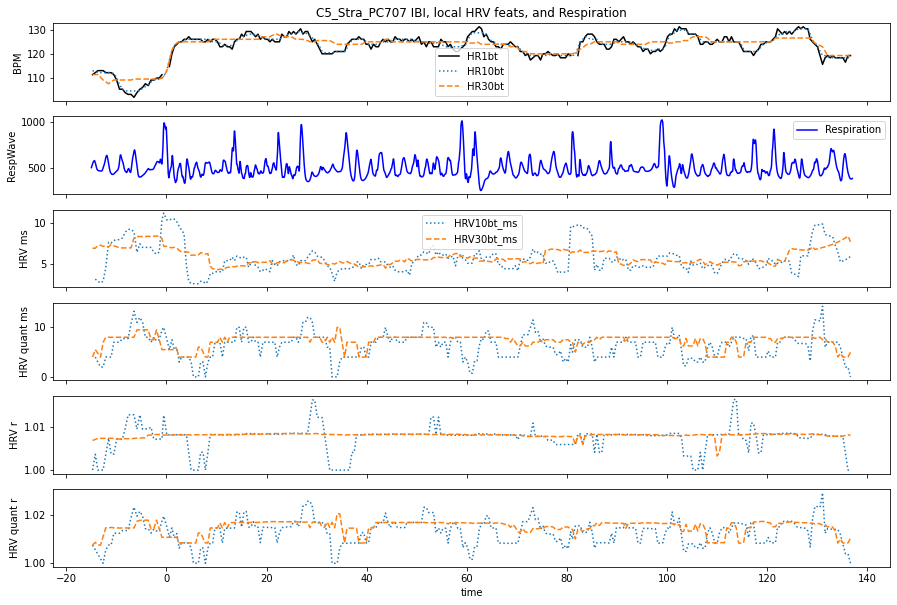

In [37]:
sig_ex = 'C5_Stra_PC707'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(6, 1,figsize = [15,10],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[1].set_xlabel('Time (s), piece')
ax[1].set_ylabel('RespWave')
HRV['HRV10bt_ms'].plot(ax=ax[2],style=':')
HRV['HRV30bt_ms'].plot(ax=ax[2],style='--')
ax[2].set_ylabel('HRV ms')
HRV['HRV10bt_qms'].plot(ax=ax[3],style=':')
HRV['HRV30bt_qms'].plot(ax=ax[3],style='--')
ax[3].set_ylabel('HRV quant ms')
HRV['HRV10bt_r'].plot(ax=ax[4],style=':')
HRV['HRV30bt_r'].plot(ax=ax[4],style='--')
ax[4].set_ylabel('HRV r')
HRV['HRV10bt_ar'].plot(ax=ax[5],style=':')
HRV['HRV30bt_ar'].plot(ax=ax[5],style='--')
ax[5].set_ylabel('HRV quant r')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV feats, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV','Resp'])+'.png',dpi=mydpi)
plt.show()

The plot above shows the instantaneous heart rate above in red, IBI transformed into BPM for more easily read units, and the two line (blue and orange) ECG recordings (256 hz) from which beats were infered during the conducting on a piece of orchestral music. The two noise-like deviations are at the start (around 0 s) and 82 s into this piece of music. We can zoom into these moments to see what is happening in the ECG signal that might results in these big fluctuations in IBI. 

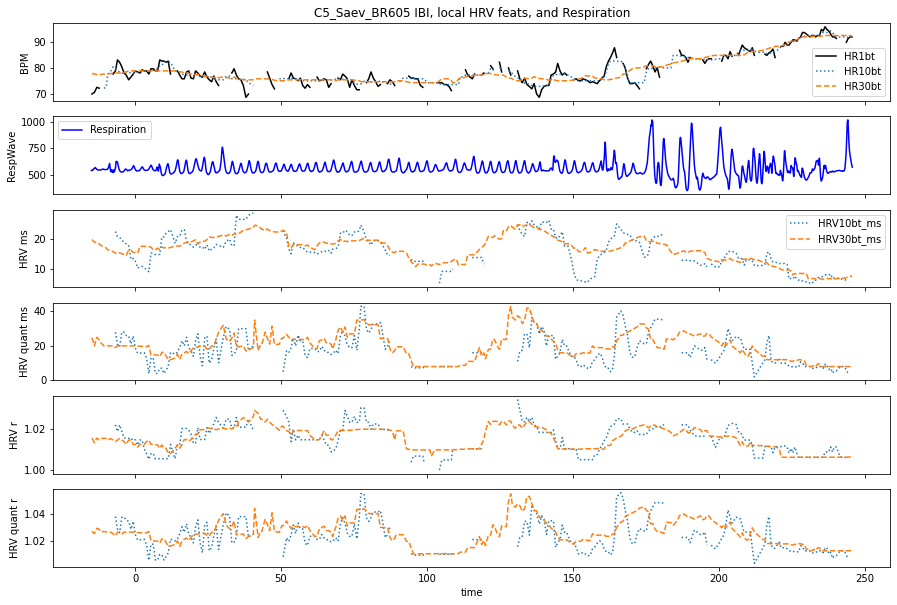

In [38]:
sig_ex = 'C5_Saev_BR605'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(6, 1,figsize = [15,10],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[1].set_xlabel('Time (s), piece')
ax[1].set_ylabel('RespWave')
HRV['HRV10bt_ms'].plot(ax=ax[2],style=':')
HRV['HRV30bt_ms'].plot(ax=ax[2],style='--')
ax[2].set_ylabel('HRV ms')
HRV['HRV10bt_qms'].plot(ax=ax[3],style=':')
HRV['HRV30bt_qms'].plot(ax=ax[3],style='--')
ax[3].set_ylabel('HRV quant ms')
HRV['HRV10bt_r'].plot(ax=ax[4],style=':')
HRV['HRV30bt_r'].plot(ax=ax[4],style='--')
ax[4].set_ylabel('HRV r')
HRV['HRV10bt_ar'].plot(ax=ax[5],style=':')
HRV['HRV30bt_ar'].plot(ax=ax[5],style='--')
ax[5].set_ylabel('HRV quant r')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV feats, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV','Resp'])+'.png',dpi=mydpi)
plt.show()

### Sensor noise deviations
In on ther measurements, sudden HR deviations are the result of sensor noise confusing the IBI extraction algorithm, like in this recording of heart rate from a brass player during Clapping Music.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


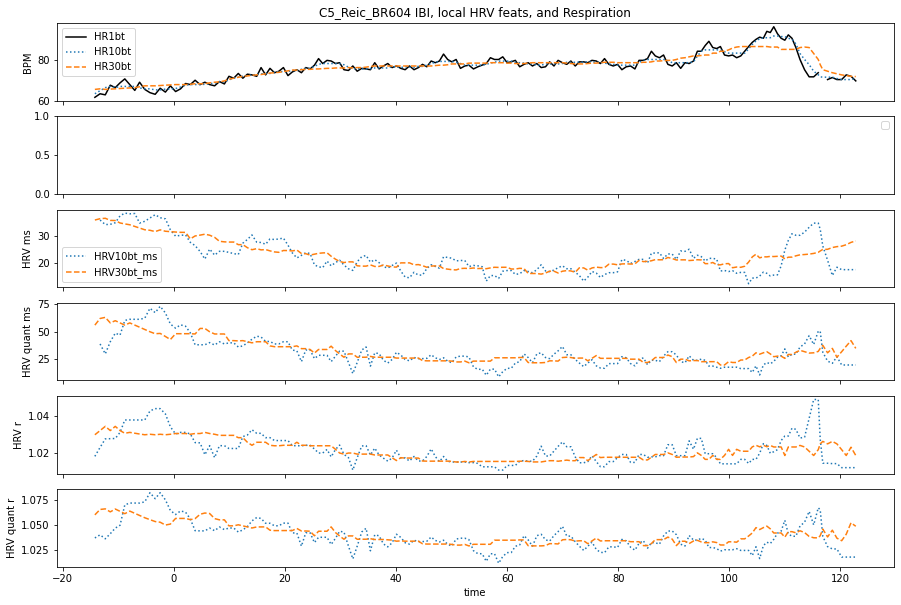

In [40]:
sig_ex = 'C5_Reic_BR604'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(6, 1,figsize = [15,10],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
HRV['HRV10bt_ms'].plot(ax=ax[2],style=':')
HRV['HRV30bt_ms'].plot(ax=ax[2],style='--')
ax[2].set_ylabel('HRV ms')
HRV['HRV10bt_qms'].plot(ax=ax[3],style=':')
HRV['HRV30bt_qms'].plot(ax=ax[3],style='--')
ax[3].set_ylabel('HRV quant ms')
HRV['HRV10bt_r'].plot(ax=ax[4],style=':')
HRV['HRV30bt_r'].plot(ax=ax[4],style='--')
ax[4].set_ylabel('HRV r')
HRV['HRV10bt_ar'].plot(ax=ax[5],style=':')
HRV['HRV30bt_ar'].plot(ax=ax[5],style='--')
ax[5].set_ylabel('HRV quant r')
ax[0].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV feats, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV','Resp'])+'.png',dpi=mydpi)
plt.show()

### Surprise deviations in wide swinging heart rates

Some people, and some players, show a lot of natural variation in their heart rates, making noise handling a bit more difficult. This measurements of a bassoonist has what looks like natural swings of heart rate doubling within intervals of 30 s, but also a lot of potential moments of noise. 

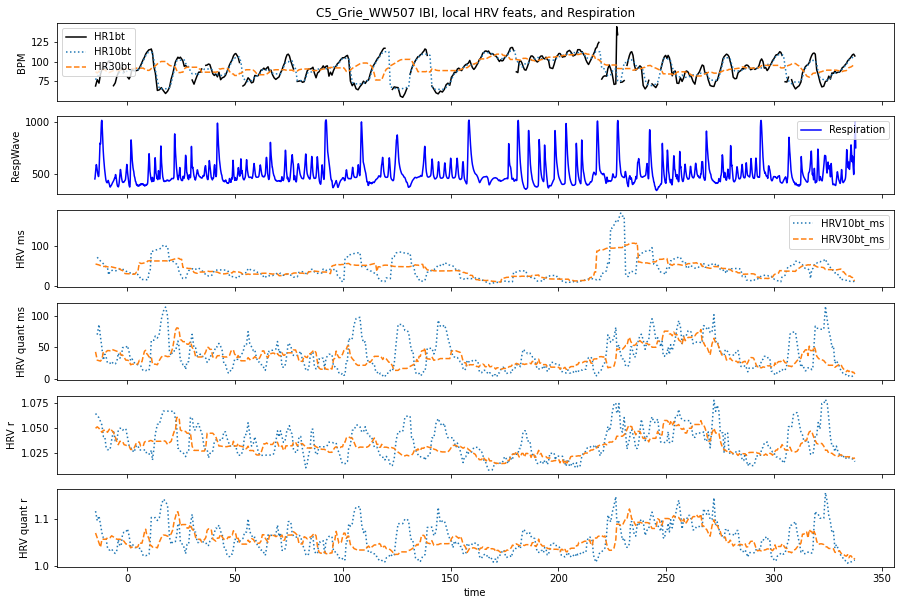

In [42]:
sig_ex = 'C5_Grie_WW507'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(6, 1,figsize = [15,10],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[1].set_xlabel('Time (s), piece')
ax[1].set_ylabel('RespWave')
HRV['HRV10bt_ms'].plot(ax=ax[2],style=':')
HRV['HRV30bt_ms'].plot(ax=ax[2],style='--')
ax[2].set_ylabel('HRV ms')
HRV['HRV10bt_qms'].plot(ax=ax[3],style=':')
HRV['HRV30bt_qms'].plot(ax=ax[3],style='--')
ax[3].set_ylabel('HRV quant ms')
HRV['HRV10bt_r'].plot(ax=ax[4],style=':')
HRV['HRV30bt_r'].plot(ax=ax[4],style='--')
ax[4].set_ylabel('HRV r')
HRV['HRV10bt_ar'].plot(ax=ax[5],style=':')
HRV['HRV30bt_ar'].plot(ax=ax[5],style='--')
ax[5].set_ylabel('HRV quant r')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV feats, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV','Resp'])+'.png',dpi=mydpi)
plt.show()

# Local Heart Rate

How local can we make heart rate calculations? Given risk of noise, given HRV? 

How rapidly is heart rate changing in performance conditions? 

### N beats medians vs N seconds averages (speed)

Instead of working with the inverse IBI intervals, heart rate is often calculated over a specific interval of time: the average heart rate over 15s, 60s, 300s. 

Exactly how that average is calculated depends on how heart rate is being stored. With a continuous ECG signal, spectral analysis on the digital signal can identify the peak power of cardiac activity within a set frame of signal. From an IBI lists, the average heart rate may be taken from the average beat length detected within a associated intervals of time. 

For the following analyses, we are working with IBI lists, but using a variation of the local average. *Beat counts vs time intervals* Because the heart rates vary some much in these series, the number of beats caught in any given time interval varies substantially. For easy of calculations, we opt to calculate heart rate over a set number of beats rather than a set interval of time. This ensures a stable amount of information informing each value, regardless of heart rate. *Median vs mean* calculations over a small number of beats is vulnerable to the influence of outliers, either from sensor noise that wasn't filtered out or extremely local deviate heart beats that do not reflect trends of interest. The median heart beat is a more stable representative of a small data set than the mean when such outliers are likely. 

*centered median N count heart beat* The median heart beat over time behaves quite differently from the moving average. Maybe I should show that. 



### 1 beat vs 10 beats vs 30 beats (reliability vs precision)


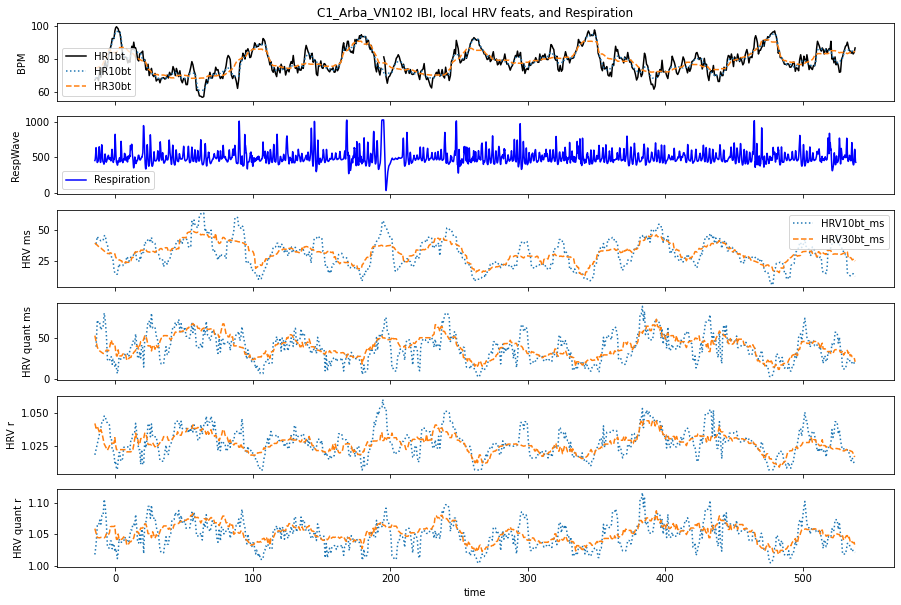

In [43]:
sig_ex = 'C1_Arba_VN102'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(6, 1,figsize = [15,10],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[1].set_xlabel('Time (s), piece')
ax[1].set_ylabel('RespWave')
HRV['HRV10bt_ms'].plot(ax=ax[2],style=':')
HRV['HRV30bt_ms'].plot(ax=ax[2],style='--')
ax[2].set_ylabel('HRV ms')
HRV['HRV10bt_qms'].plot(ax=ax[3],style=':')
HRV['HRV30bt_qms'].plot(ax=ax[3],style='--')
ax[3].set_ylabel('HRV quant ms')
HRV['HRV10bt_r'].plot(ax=ax[4],style=':')
HRV['HRV30bt_r'].plot(ax=ax[4],style='--')
ax[4].set_ylabel('HRV r')
HRV['HRV10bt_ar'].plot(ax=ax[5],style=':')
HRV['HRV30bt_ar'].plot(ax=ax[5],style='--')
ax[5].set_ylabel('HRV quant r')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV feats, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV','Resp'])+'.png',dpi=mydpi)
plt.show()

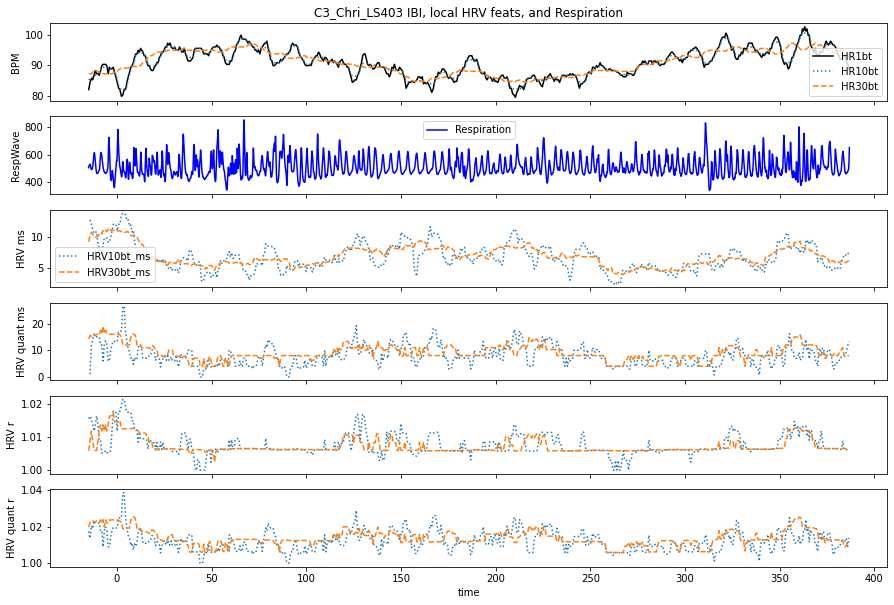

In [44]:
sig_ex = 'C3_Chri_LS403'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
HRV = hrv_beatfeats(IBI.index,IBI.IBI)

fig, (ax) = plt.subplots(6, 1,figsize = [15,10],sharex = True)
HR['HR1bt'].plot(ax=ax[0],color='k')
HR['HR10bt'].plot(ax=ax[0],style=':')
HR['HR30bt'].plot(ax=ax[0],style='--')
ax[0].set_ylabel('BPM')
ax[1].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[1].set_xlabel('Time (s), piece')
ax[1].set_ylabel('RespWave')
HRV['HRV10bt_ms'].plot(ax=ax[2],style=':')
HRV['HRV30bt_ms'].plot(ax=ax[2],style='--')
ax[2].set_ylabel('HRV ms')
HRV['HRV10bt_qms'].plot(ax=ax[3],style=':')
HRV['HRV30bt_qms'].plot(ax=ax[3],style='--')
ax[3].set_ylabel('HRV quant ms')
HRV['HRV10bt_r'].plot(ax=ax[4],style=':')
HRV['HRV30bt_r'].plot(ax=ax[4],style='--')
ax[4].set_ylabel('HRV r')
HRV['HRV10bt_ar'].plot(ax=ax[5],style=':')
HRV['HRV30bt_ar'].plot(ax=ax[5],style='--')
ax[5].set_ylabel('HRV quant r')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' IBI, local HRV feats, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV','Resp'])+'.png',dpi=mydpi)
plt.show()

In [45]:
HRV.columns

Index(['IBI', 'HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
       'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar'],
      dtype='object')

### Retaining meaningful fluctuations in HR

To underline how the smoothing parameters proiritise different kinds of information in these cardiac measurements (interval and type), below are the features extracted from a section of performers, the second violinists during one piece of music. The Carnival of Venice alternates between orchestra and soloist, and some fluctuations are at the rate of these alternations and some simultaneous changes are at a smaller scale, maybe at the phrase level rather than section. 

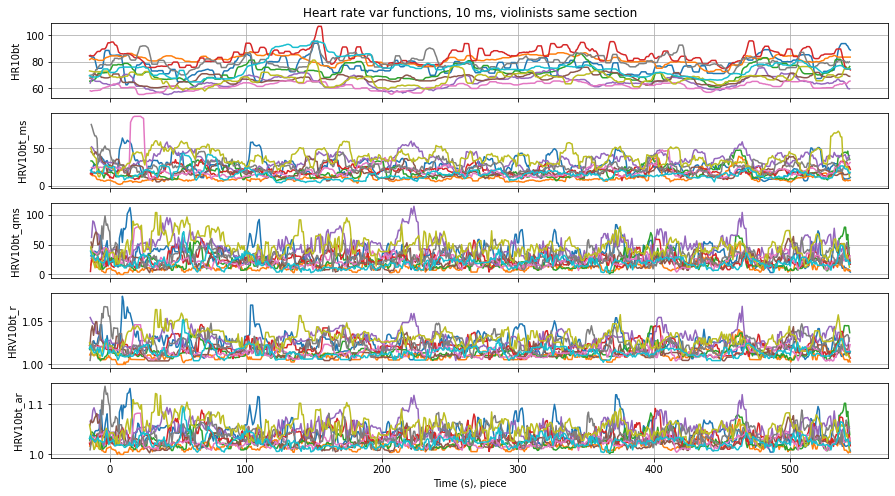

In [90]:
sig_ex = 'C2_Arba_VN'
fig, (ax) = plt.subplots(5, 1,figsize = [15,8],sharex = True)
# tag = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
#        'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
tag = ['HR10bt','HRV10bt_ms', 'HRV10bt_qms','HRV10bt_r','HRV10bt_ar']
for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
    HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
    HRV = hrv_beatfeats(IBI.index,IBI.IBI)

    for j in range(len(ax)):
        if j<1:
            HR[tag[j]].plot(ax=ax[j])
        else:
            HRV[tag[j]].plot(ax=ax[j])
ax[4].set_xlabel('Time (s), piece')
ax[0].set_title('Heart rate var functions, 10 ms, violinists same section')
for j in range(5):
    ax[j].grid()
#     ax[j].set_ylim([55,115])
    ax[j].set_ylabel(tag[j])
    
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV10feats'])+'.png',dpi=mydpi)
plt.show()

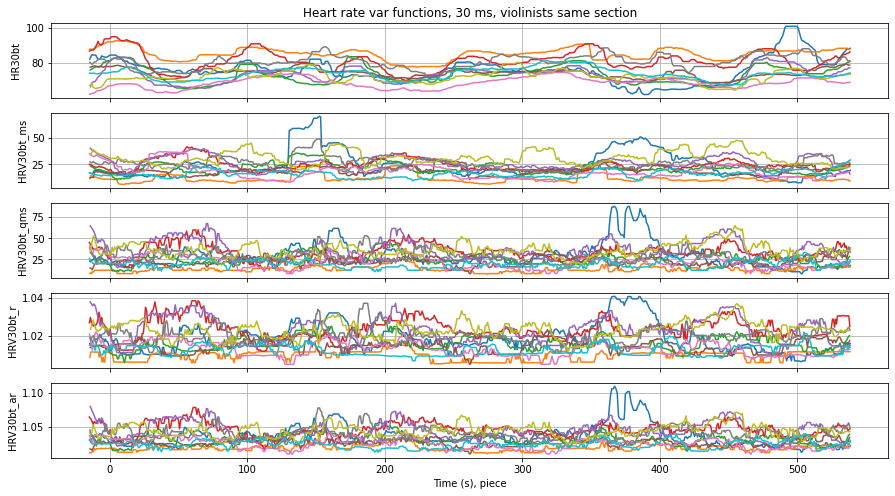

In [89]:
sig_ex = 'C1_Arba_VN'
fig, (ax) = plt.subplots(5, 1,figsize = [15,8],sharex = True)
# tag = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
#        'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
tag = ['HR30bt','HRV30bt_ms', 'HRV30bt_qms','HRV30bt_r','HRV30bt_ar']
for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
    HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
    HRV = hrv_beatfeats(IBI.index,IBI.IBI)

    for j in range(len(ax)):
        if j<1:
            HR[tag[j]].plot(ax=ax[j])
        else:
            HRV[tag[j]].plot(ax=ax[j])
ax[4].set_xlabel('Time (s), piece')
ax[0].set_title('Heart rate var functions, 30 ms, violinists same section')
for j in range(5):
    ax[j].grid()
#     ax[j].set_ylim([55,115])
    ax[j].set_ylabel(tag[j])
    
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV30feats'])+'.png',dpi=mydpi)
plt.show()

Smoothing these heart rate time series with 30 s averages retaines only a rough and temporally distorted contour, removing numerous shared peaks between players performing the same part (ex 150s). Smoothing average at 10 s retains more, but still shifts the timing of changes to make concurrent local changes is obscured. 

The median tiem series are filtering higher frequency fluctuations but also relatin more alignment in the timing of heart rate changes. The 10 bt median is close to the rate of common patterns in heart rate oscillations, many instances are retained but not all. If the quality of IBI information is sufficiently stable maybe an 8 bt median would be more reliable yet. 

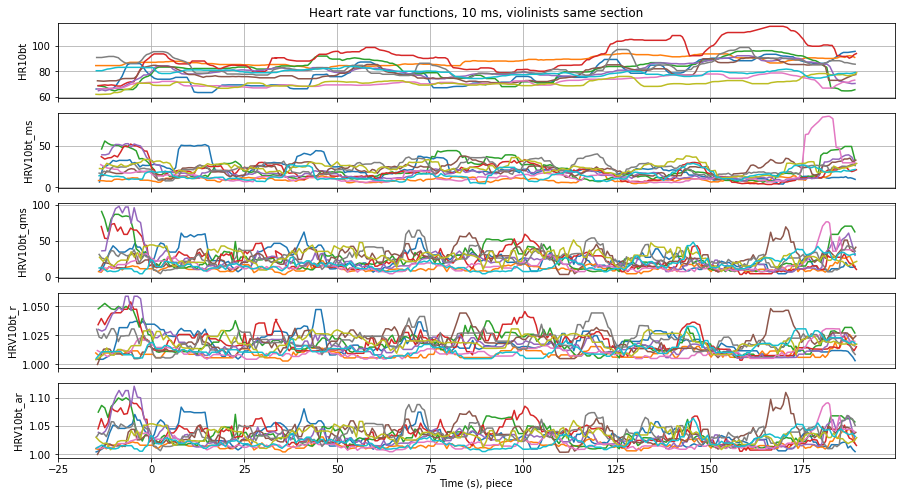

In [48]:
sig_ex = 'C1_Tcha_VN'
fig, (ax) = plt.subplots(5, 1,figsize = [15,8],sharex = True)
# tag = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
#        'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
tag = ['HR10bt','HRV10bt_ms', 'HRV10bt_qms','HRV10bt_r','HRV10bt_ar']
for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
    HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
    HRV = hrv_beatfeats(IBI.index,IBI.IBI)

    for j in range(len(ax)):
        if j<1:
            HR[tag[j]].plot(ax=ax[j])
        else:
            HRV[tag[j]].plot(ax=ax[j])
ax[4].set_xlabel('Time (s), piece')
ax[0].set_title('Heart rate var functions, 10 ms, violinists same section')
for j in range(5):
    ax[j].grid()
#     ax[j].set_ylim([55,115])
    ax[j].set_ylabel(tag[j])
    
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV10feats'])+'.png',dpi=mydpi)
plt.show()

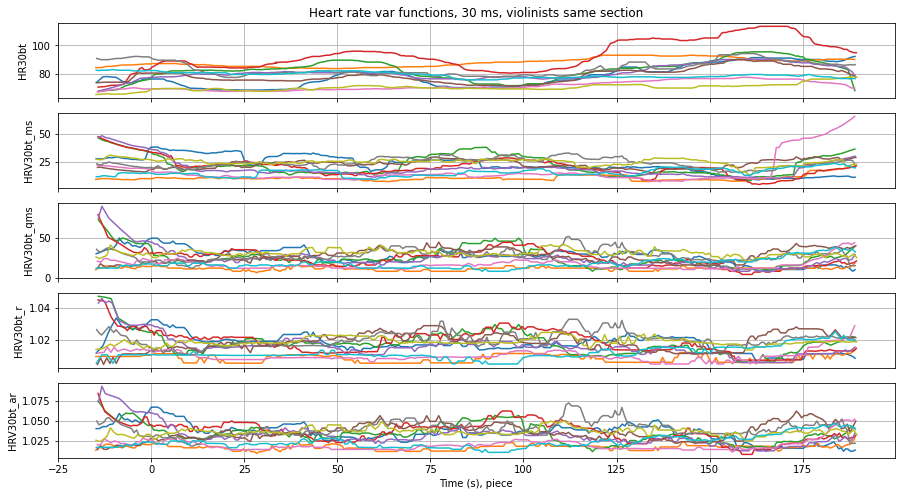

In [49]:
sig_ex = 'C1_Tcha_VN'
fig, (ax) = plt.subplots(5, 1,figsize = [15,8],sharex = True)
# tag = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
#        'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
tag = ['HR30bt','HRV30bt_ms', 'HRV30bt_qms','HRV30bt_r','HRV30bt_ar']
for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
    HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
    HRV = hrv_beatfeats(IBI.index,IBI.IBI)

    for j in range(len(ax)):
        if j<1:
            HR[tag[j]].plot(ax=ax[j])
        else:
            HRV[tag[j]].plot(ax=ax[j])
ax[4].set_xlabel('Time (s), piece')
ax[0].set_title('Heart rate var functions, 30 ms, violinists same section')
for j in range(5):
    ax[j].grid()
#     ax[j].set_ylim([55,115])
    ax[j].set_ylabel(tag[j])
    
plt.savefig(plot_loc+'_'.join([sig_ex,'HRV30feats'])+'.png',dpi=mydpi)
plt.show()

Looking at a shorter piece with a more typical structure, these violinists show again somewhat similar contours with the 30s means, but the there is a lot of shared and distinguising variation in heart rate that are most visibile in the 10 bt medians. 

However, in this piece as well, it seems like the 10 bt median is still flattening local changes in heart rate that seem to be coordinated across players in the same section. Again, if the quality of the IBI measurements are sufficiently high, it may be that 8 bts would be a better threshold, and there maybe conditions when then 1 bt time series are worth working with.

Heart rates fluctuate rapidly in people playing music. The work of performance is demanding and variable in relationship to the specific actions. There are also other aspects of a person's cognitive state and health condition that can influence the particular cardiac dynamics measured in these contexts. 

Resample these cardiac features at an even 4 hz to make them comparable between bodies concurrently active. We can then use comparative measures to evaluate what kind of information shared between players is retained through the various transformations. 

In [94]:
sig_ex = 'C1_Arba_VN'
i = 0
V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sf = 4
time_s = np.arange(np.round(sig_t.iloc[0]),np.round(sig_t.iloc[-1]),1/sf)
df_sig = pd.DataFrame(index = time_s)
cols = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
       'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
HR_dfs = {}
for c in cols:
    HR_dfs[c] = df_sig.copy()

for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
    HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
    HRV = hrv_beatfeats(IBI.index,IBI.IBI)
    rf = mh.refeats(HR,time_s)
    for c in ['HR1bt','HR10bt','HR30bt']:
        HR_dfs[c].loc[:,i] = rf.loc[:,c]
    rf = mh.refeats(HRV,time_s)
    for c in ['HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
       'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']:
        HR_dfs[c].loc[:,i] = rf.loc[:,c]

In [67]:
sig_ex = 'C2_Grie_VA'
i = 0
V = pd.read_csv(data_loc + sig_ex+str(i+301)+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sf = 4
time_s = np.arange(np.round(sig_t.iloc[0]),np.round(sig_t.iloc[-1]),1/sf)
df_sig = pd.DataFrame(index = time_s)
cols = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
       'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
HR_dfs = {}
for c in cols:
    HR_dfs[c] = df_sig.copy()

for i in [0,1,2,3,4,6,7]:
    V = pd.read_csv(data_loc + sig_ex+str(i+301)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
    HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
    HRV = hrv_beatfeats(IBI.index,IBI.IBI)
    rf = mh.refeats(HR,time_s)
    for c in ['HR1bt','HR10bt','HR30bt']:
        HR_dfs[c].loc[:,i] = rf.loc[:,c]
    rf = mh.refeats(HRV,time_s)
    for c in ['HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
       'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']:
        HR_dfs[c].loc[:,i] = rf.loc[:,c]

HR10bt rho =  0.405 (0.168), SMMS ratio 0.67
HR30bt rho =  0.45 (0.177), SMMS ratio 0.45


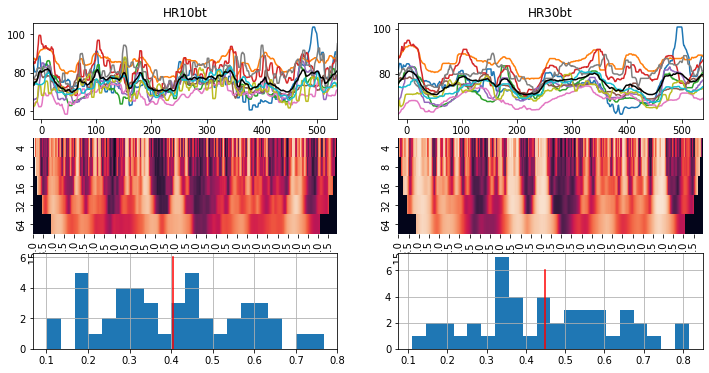

HRV10bt_ms rho =  0.096 (0.154), SMMS ratio 0.446
HRV30bt_ms rho =  0.12 (0.207), SMMS ratio 0.363


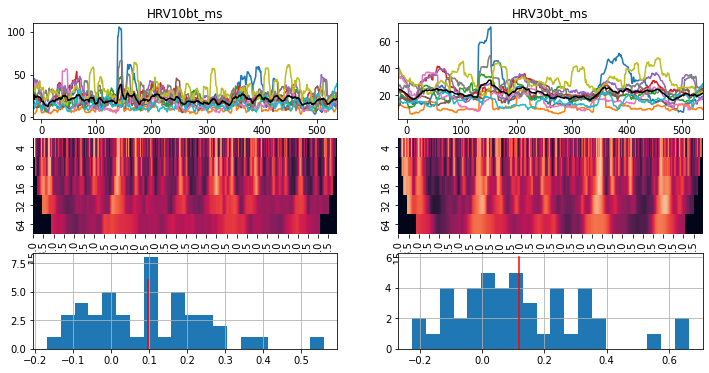

HRV10bt_qms rho =  0.06 (0.124), SMMS ratio 0.42
HRV30bt_qms rho =  0.063 (0.212), SMMS ratio 0.331


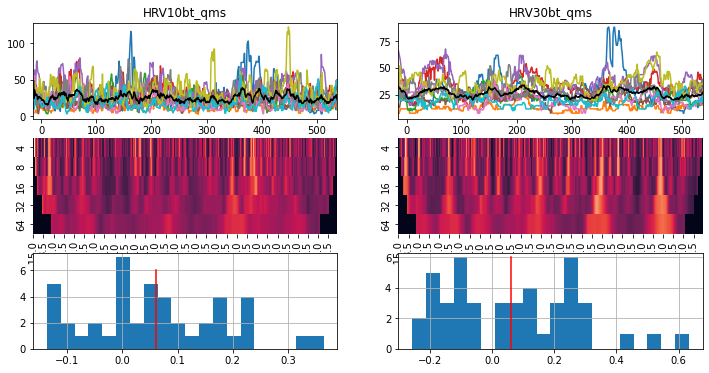

HRV10bt_r rho =  0.047 (0.117), SMMS ratio 0.382
HRV30bt_r rho =  0.02 (0.186), SMMS ratio 0.333


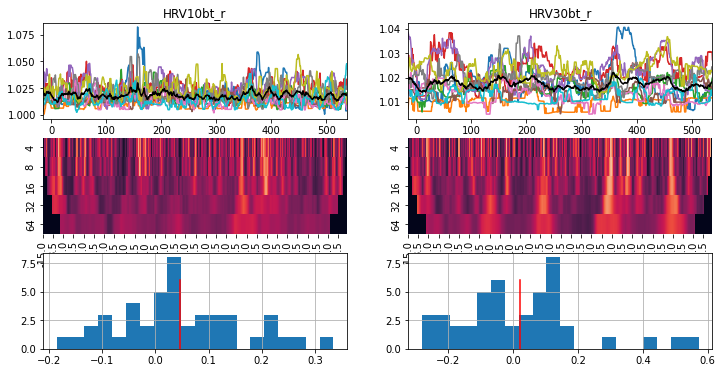

HRV10bt_ar rho =  0.039 (0.112), SMMS ratio 0.385
HRV30bt_ar rho =  0.024 (0.197), SMMS ratio 0.329


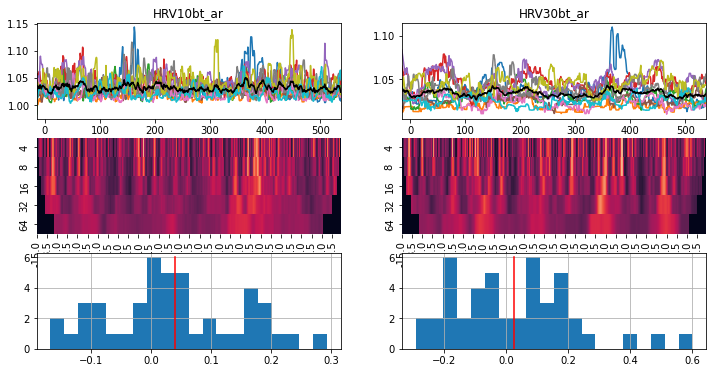

In [95]:
cols1 = ['HR10bt','HRV10bt_ms', 'HRV10bt_qms','HRV10bt_r','HRV10bt_ar']
cols2 = ['HR30bt','HRV30bt_ms', 'HRV30bt_qms','HRV30bt_r','HRV30bt_ar']

frame_sizes = [4,8,16,32,64]
for i in range(len(cols1)):
    c = cols1[i]
    d = cols2[i]
    fig, (ax) = plt.subplots(3,2,figsize = [12,6])
    HR_dfs[c].plot(ax=ax[0,0],legend=False)
    HR_dfs[c].mean(axis=1).plot(ax=ax[0,0],color='k')
    ax[0,0].set_title(c)
    HR_dfs[d].plot(ax=ax[0,1],legend=False)
    HR_dfs[d].mean(axis=1).plot(ax=ax[0,1],color='k')

    ax[0,1].set_title(d)
#     ax[0,0].autoscale(enable=True, axis='x', tight=True)
#     ax[0,1].autoscale(enable=True, axis='x', tight=True)
    ax[0,0].set_xlim([HR_dfs[c].index[0],HR_dfs[c].index[-1]])
    ax[0,1].set_xlim([HR_dfs[d].index[0],HR_dfs[c].index[-1]])

    pcoor = mh.scaledcoh(HR_dfs[c],frame_sizes)
    no_na = pcoor.fillna(0)
    chart = sns.heatmap(data=no_na.transpose(),vmin=0, vmax=1, ax=ax[1,0],cbar=False)#
    pcoor = mh.scaledcoh(HR_dfs[d],frame_sizes)
    no_na = pcoor.fillna(0)
    chart = sns.heatmap(data=no_na.transpose(),vmin=0, vmax=1, ax=ax[1,1],cbar=False)#

    a = HR_dfs[c].corr(method='spearman')
    keep = np.triu(np.ones(a.shape),1).astype('bool').reshape(a.size)
    b = (a.stack()[keep])
    b.hist(bins = 20,ax=ax[2,0])
    m = b.mean()
    ax[2,0].plot(m*np.array([1,1]),[0,6],color = 'r')
    devR = HR_dfs[c].mean(axis=1).std()/HR_dfs[c].std(axis=0).mean()
    print(' '.join([c,'rho = ', str(np.round(m,3)),'('+str(np.round(b.std(),3))+'),','SMMS ratio',str(np.round(devR,3))]))
    a = HR_dfs[d].corr(method='spearman')
    b = (a.stack()[keep])
    b.hist(bins = 20,ax=ax[2,1])
    dm = b.mean()
    ax[2,1].plot(dm*np.array([1,1]),[0,6],color = 'r')
    devR = HR_dfs[c].diff().mean(axis=1).std()/HR_dfs[c].diff().std(axis=0).mean()
    print(' '.join([d,'rho = ',str(np.round(dm,3)),'('+str(np.round(b.std(),3))+'),','SMMS ratio',str(np.round(devR,3))]))
    plt.savefig(plot_loc+'_'.join([sig_ex,c,'1030featCoh'])+'.png',dpi=mydpi)
    plt.show()

# HR and HRV

The relationship between heart rate and heartrate variability is quite strong in many of these recordings. 

These different measures of HRV make concrete corrections for some direct numerical consequences, however, there seems to be a relationship beyond that of inverse absolute influence. 

In [ ]:
cols = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
       'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
#HR_dfs = {}

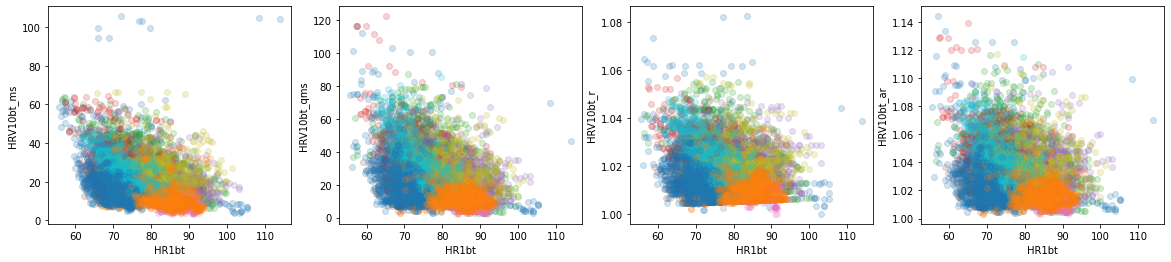

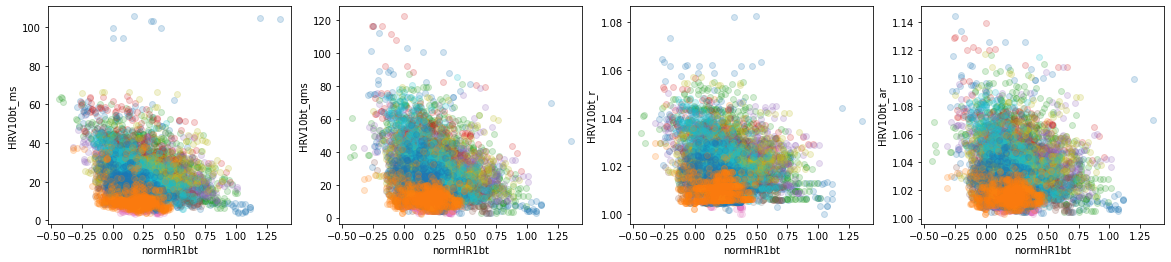

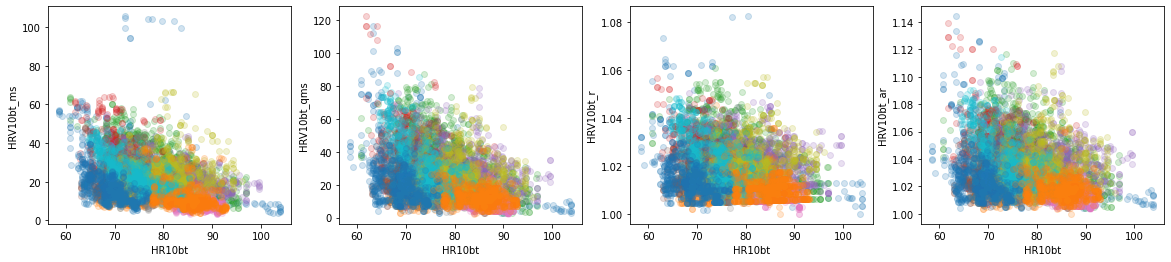

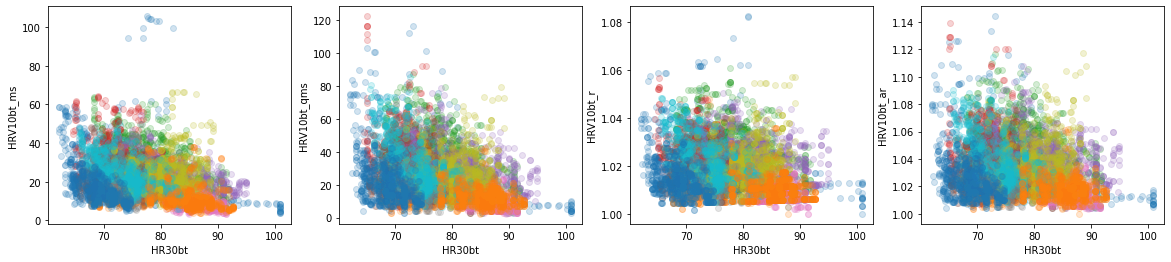

In [83]:
sig_ex = 'C1_Arba'
sigfiles = []
for f in os.listdir(data_loc):
    if f.startswith(sig_ex):
        if f.endswith('IBI.csv'):
            sigfiles.append(f)
# tag = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
#        'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
HRtag = 'normHR1bt'
HRVtags = ['HRV10bt_ms', 'HRV10bt_qms','HRV10bt_r','HRV10bt_ar']
for HRtag in ['HR1bt','normHR1bt','HR10bt','HR30bt']:
    fig, (ax) = plt.subplots(1,4,figsize = [20,4],sharex = True)
    for i in range(len(sigfiles)):
        V = pd.read_csv(data_loc + sigfiles[i], index_col = 0)
        sig_t = V['p_sTime']
        sig_v = V['Interbeat Interval (MS)']
        IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
        HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
        HRV = hrv_beatfeats(IBI.index,IBI.IBI)

        for j in range(len(ax)):
            ax[j].scatter(x = HR[HRtag],y = HRV[HRVtags[j]],alpha = 0.2)
    for j in range(len(ax)):
            ax[j].set_xlabel(HRtag) 
            ax[j].set_ylabel(HRVtags[j])
    plt.show()

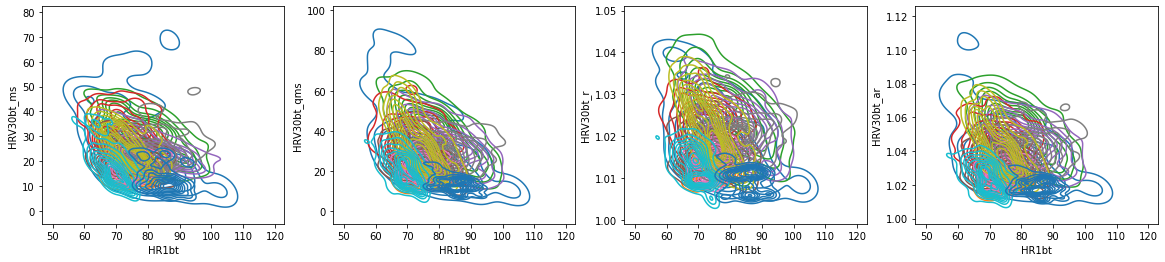

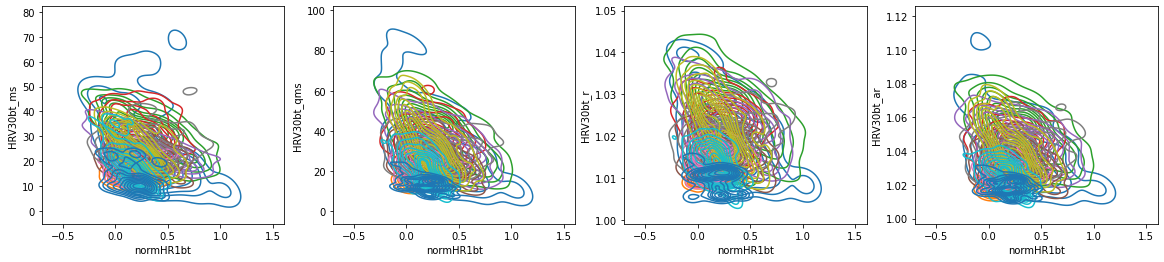

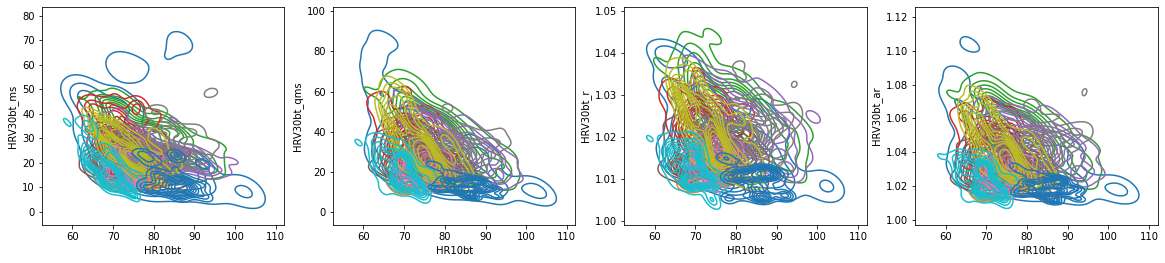

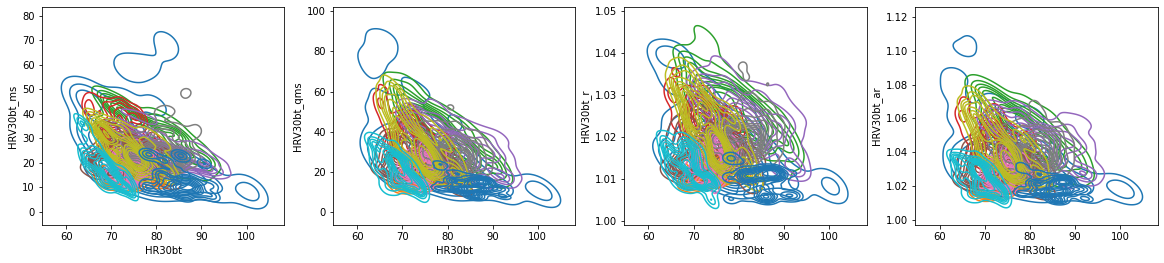

In [85]:
sig_ex = 'C1_Arba_VN'
sigfiles = []
for f in os.listdir(data_loc):
    if f.startswith(sig_ex):
        if f.endswith('IBI.csv'):
            sigfiles.append(f)
# tag = ['HR1bt','HR10bt','HR30bt','HRV10bt_ms', 'HRV30bt_ms', 'HRV10bt_qms', 'HRV30bt_qms',
#        'HRV10bt_r', 'HRV30bt_r', 'HRV10bt_ar', 'HRV30bt_ar']
# HRVtags = ['HRV10bt_ms', 'HRV10bt_qms','HRV10bt_r','HRV10bt_ar']
HRVtags = ['HRV30bt_ms', 'HRV30bt_qms','HRV30bt_r','HRV30bt_ar']
for HRtag in ['HR1bt','normHR1bt','HR10bt','HR30bt']:
    fig, (ax) = plt.subplots(1,4,figsize = [20,4],sharex = True)
    for i in range(len(sigfiles)):
        V = pd.read_csv(data_loc + sigfiles[i], index_col = 0)
        sig_t = V['p_sTime']
        sig_v = V['Interbeat Interval (MS)']
        IBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
        HR = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
        HRV = hrv_beatfeats(IBI.index,IBI.IBI)

        for j in range(len(ax)):
            sns.kdeplot(x = HR[HRtag],y = HRV[HRVtags[j]],ax=ax[j])
            #ax[j].scatter(x = HR[HRtag],y = HRV[HRVtags[j]],alpha = 0.2)
    for j in range(len(ax)):
            ax[j].set_xlabel(HRtag) 
            ax[j].set_ylabel(HRVtags[j])
    plt.show()

In [86]:
# test rehearsal vs performance HR/HRV slops
# can we model the HRV range restrictions with HR 
# is there a substantial difference in shape for 10bt vs 30bt on HRV measures? 
    # IE do we need mroe time to assess and does the extra time blur the HR associats?

In [76]:
HR

IBI      HR1bt  normHR1bt     HR10bt     HR30bt
time                                                     
-14.712   683  87.847731   0.393403  90.909091  90.909091
-14.048   660  90.909091   0.495449  90.909091  90.432057
-13.383   640  93.750000   0.590146  90.909091  89.955022
-12.758   660  90.909091   0.495449  91.186253  90.158234
-12.094   656  91.463415   0.513926  91.463415  89.955022
...       ...        ...        ...        ...        ...
 186.279  699  85.836910   0.326376  86.830680  86.083923
 186.982  691  86.830680   0.359502  86.830680  86.330935
 187.686  691  86.830680   0.359502  86.333795  86.580808
 188.428  734  81.743869   0.189941  85.836910  86.330935
 189.131  734  81.743869   0.189941  85.592708  86.580808

[286 rows x 5 columns]

In [76]:
HR

IBI      HR1bt  normHR1bt     HR10bt     HR30bt
time                                                     
-14.712   683  87.847731   0.393403  90.909091  90.909091
-14.048   660  90.909091   0.495449  90.909091  90.432057
-13.383   640  93.750000   0.590146  90.909091  89.955022
-12.758   660  90.909091   0.495449  91.186253  90.158234
-12.094   656  91.463415   0.513926  91.463415  89.955022
...       ...        ...        ...        ...        ...
 186.279  699  85.836910   0.326376  86.830680  86.083923
 186.982  691  86.830680   0.359502  86.830680  86.330935
 187.686  691  86.830680   0.359502  86.333795  86.580808
 188.428  734  81.743869   0.189941  85.836910  86.330935
 189.131  734  81.743869   0.189941  85.592708  86.580808

[286 rows x 5 columns]

# Normalising cardiac features of with active conditions
In many conditions, the research question is better answered when inter-individual differences are minimised through normalisation. 

Standard physiological normalisation startegies are usually constant value corrections to a calm baseline measureent, or z normalisation to match variance and means during measurements with 

# Heart Rate and Heart Rate Variability in the active body
Quick summary and implications